# QNLP Tutorial (IEEE Quantum Week 2023):  A QNN Introduction

This notebook explores the design space of QNNs trained on synthetic data or on a NLP dataset.  The goal of this tutorial is to introduce several methods for feature embedding, ansatz construction, and label assignment.  

In this tutorial we will use two datsets:  first, is a set of random feature vectors with random labels, constructed as in the  `MADELON` dataset.   The second dataset is derived from the `IMDB` (Internet Movie DataBase) dataset: the original data is a collection of 50K text reviews, labeled by sentiment (positive or negative).  Prior to this tutorial these features were embedded using length 2 feature vectors using `doc2vec`  embedding (introduced in the previous session).

In [1]:
from pennylane import numpy as np
import pennylane as qml

import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import make_moons,make_classification

# Construct Unstructured Data (Synthetic)

The `TwoMoons` dataset constructs a sythetic dataset of 2 dimensional features.  The two classes are half-cirles. 

$200$ samples are generated and $10\%$ are held out as the test data. 

These functions are wrappers of existing functions in `scikit-learn`. 

In [2]:
# Make a dataset of two moons
def moons(samples, noise = 0.1, random_state=2023):
    """
    Generates a dataset of points with 1/0 labels inside a given radius.

    Args:
        samples (int): number of samples to generate
        center (tuple): center of the circle
        radius (float: radius of the circle

    Returns:
        Xvals (array[tuple]): coordinates of points
        yvals (array[int]): classification labels
    """
    X, y = make_moons(n_samples=samples, noise=noise,random_state=random_state)
    return np.array(X, requires_grad=False), np.array(y, requires_grad=False)

In [3]:
def partition_data(X,y,test_size=0.2):
    '''
    since the synthetic datasets used in this tutorial are already shuffled
    the partitioning is just separating the first 80% of samples for traning
    and the remaining 20% are held for testing'''
    n_train_samples = int(len(X)*(1.-test_size))
    trainX = X[:n_train_samples]
    trainY = y[:n_train_samples]
    
    testX = X[n_train_samples:]
    testY = y[n_train_samples:]
    return trainX,trainY,testX,testY

In [4]:
def rescale_features(X,a=-np.pi,b=np.pi,normalize=False,discretize=False,bins=20):
    '''
    can use either simple shift/rescale of features into a range of values [a,b]
    or can use a discrete map of categorical features to rotations
    (c) unique values equally spaced in [a,b]'''
    
    Xvals = X.copy()

    if not discretize:
        Xmin = np.min(X, axis=0).numpy()
        Xmax = np.max(X, axis=0).numpy()
        Xvals = (b-a) * (Xvals - Xmin) / (Xmax - Xmin) + a
    elif discretize:
        rot_angles = np.linspace(a,b,num=len(np.unique(X)), endpoint=True)
        Xvals = np.asarray([[rot_angles[y].numpy() for y in x] for x in X])
    if normalize:
        row_norms = np.linalg.norm(Xvals,axis=1)
        Xvals = Xvals / row_norms[:, np.newaxis]
        Xvals[np.isnan(Xvals)] = 0
        mask = np.all(np.abs(Xvals) < 1e-10, axis=1)
        pos = np.where(~(mask))
        return Xvals[pos],pos
    else:
        return Xvals

In [5]:
def one_hot_encode_labels(y,L):
    '''
    replace class labels with one-hot encoded labels of length L
    example: if L = 2
    0 -> [1,0]
    1 -> [0,1]
    '''
    unique_classes = set(y)
    label_map = {}
    for idx,c in enumerate(unique_classes):
        label_vec = [0]*L
        label_vec[idx]=1
        label_map[c]=label_vec.copy()
    one_hot_y=[label_map[iy] for _,iy in enumerate(y)]
    return one_hot_y

In [130]:
def plot2d_data(X,y,fig=None, ax=None):
    SMALL_SIZE = 12
    MEDIUM_SIZE = 20
    BIGGER_SIZE = 24

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    color_map={0:'blue',1: 'orange',2:'cyan'}
    shape_map={0:'x',1:'o',2:'^'}
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    blues = y == 0
    oranges = y == 1
    brights = y == 2
    ax.scatter(X[blues, 0], X[blues, 1], c=color_map[0], s=50,marker=shape_map[0], alpha=0.75)
    ax.scatter(X[oranges, 0], X[oranges, 1], c=color_map[1], s=50,marker=shape_map[1], alpha=0.75)
    ax.scatter(X[brights, 0], X[brights, 1], c=color_map[2], s=50,marker=shape_map[1], alpha=0.75)
    #ax.scatter(X[:,0],X[:,1], c=y, s=75, alpha=0.5,cmap='bwr')
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")

In [131]:
def plot2d_boundary_data(X,y,xx,yy,z_height,fig=None, ax=None):
    SMALL_SIZE = 12
    MEDIUM_SIZE = 20
    BIGGER_SIZE = 24

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    color_map={0:'blue',1: 'orange',2:'cyan'}
    shape_map={0:'x',1:'o',2:'^'}
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    blues = y == 0
    oranges = y == 1
    brights = y == 2
    ax.scatter(X[blues, 0], X[blues, 1], c=color_map[0], s=50,marker=shape_map[0], alpha=0.75)
    ax.scatter(X[oranges, 0], X[oranges, 1], c=color_map[1], s=50,marker=shape_map[1], alpha=0.75)
    ax.scatter(X[brights, 0], X[brights, 1], c=color_map[2], s=50,marker=shape_map[1], alpha=0.75)
    #ax.scatter(X[:,0],X[:,1], c=y, s=75, alpha=0.5,cmap='bwr')
    ax.set_xlabel("$x_1$",fontsize=18)
    ax.set_ylabel("$x_2$",fontsize=18)

The individual features are not syntatically related -- each feature vector is a random point in a high-dimesional space.  We arbitrarily shift and rescale the generated vectors so that the values of the feature vectors are in the range $[0, 2\pi]$.  

In [132]:
X, y = moons(200)
X_train,y_train,X_test,y_test = partition_data(X,y)
X_train = rescale_features(X_train)
X_test = rescale_features(X_test)

Just making a quick side-by-side comparison, the features of `X_train` should be rescaled to $[-\pi,\pi]$.

Text(0.5, 1.0, 'rescaled data')

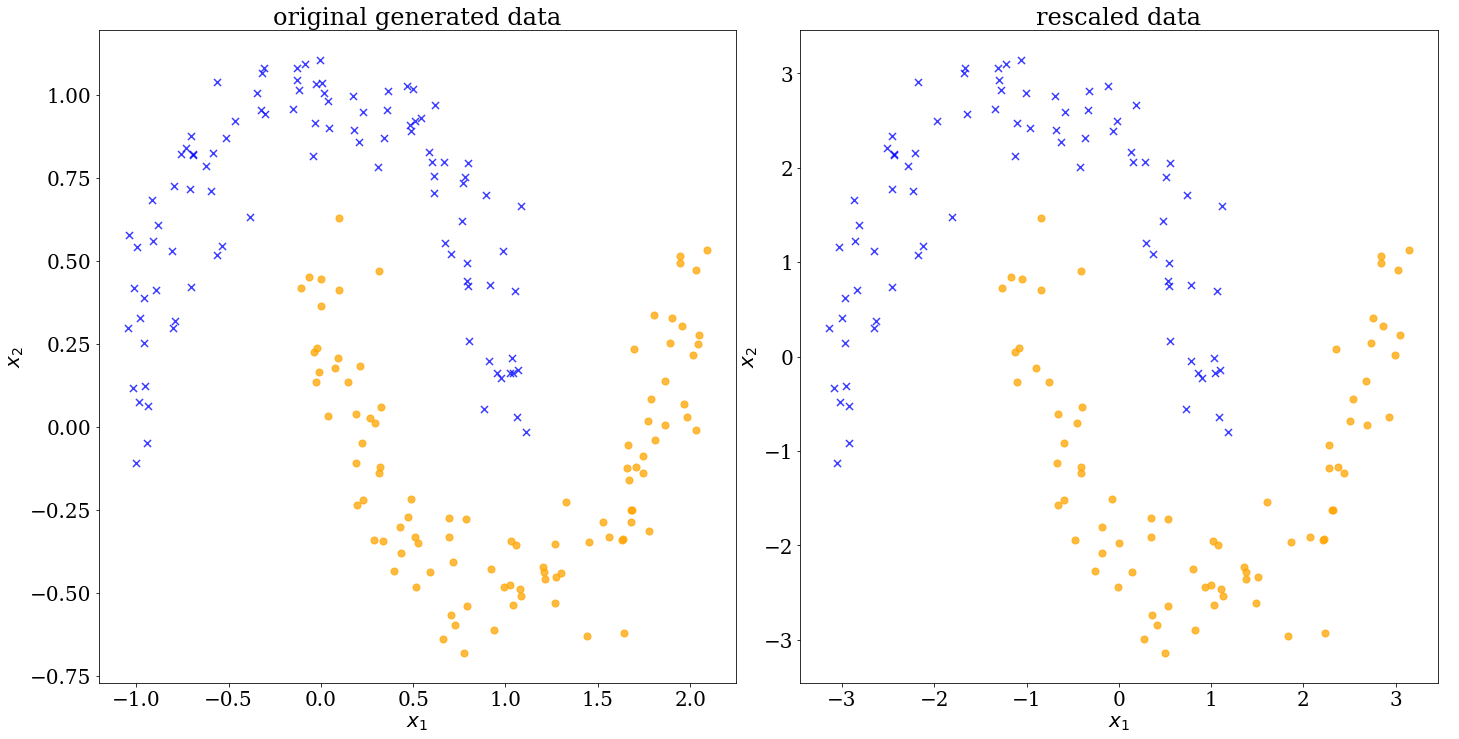

In [133]:
f, ax = plt.subplots(ncols=2,figsize=(24,12))

plt.rc('text',usetex=False)
plt.rc('font',family='serif')
plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=18)
plt.rc('legend',**{'numpoints':1,'fontsize':18,'handlelength':2})

# add a big axis, hide frame
f.add_subplot(111,frameon=False) 
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)


f.subplots_adjust( wspace=0.1,hspace=0.2 )

plot2d_data(X,y, fig=f, ax=ax[0])
ax[0].set_title("original generated data",fontsize=24)
plot2d_data(X_train,y_train,fig=f,ax=ax[1])
ax[1].set_title("rescaled data",fontsize=24)

## (Optional): A second synthetic dataset

Instead of using hte `TwoMoons` (or another `scikit-learn` dataset), you can also generate a set of random features labeled with random binary labels

# Define Layer Templates

The first template is the data-encoding layer.  This takes as an input a feature vector (x) and encodes it into a single qubit using 3 gates (RY-RZ-RY).  

In [10]:
def AngleEncodingLayer(x,dev_wires):
    '''
    Layer template that applies the rotation gate layer
    '''
    if len(x)<3*len(dev_wires):
        x_ = np.reshape(np.tile(x,3*len(dev_wires)),(-1,3))
    else:
        x_ = np.reshape(x,(-1,3))
    for idx in range(len(dev_wires)):
        qml.RY(x_[idx][0],wires=dev_wires[idx])
        qml.RZ(x_[idx][1],wires=dev_wires[idx])
        qml.RY(x_[idx][2],wires=dev_wires[idx])


The second template is the trainable ansatz layer -- for this tutorial we will use a bilayer ansatz built from interlevaed layers of CNOTS followed by trainable rotation gates. 

In [11]:
def EdgeListLayer(params,dev_wires,edge_list=[]):
    ''' Layer template that takes an edge list and builds
    entangling layer - rotation layer -  ansatz

    params: list of floats (trainable parameters)

    wires: list of int
    edge_list: list of lists for CNOT layouts
    '''
    # add entangling layer with CNOTs defined by edge_list
    if len(edge_list) > 0:
        for edx in edge_list:
            qml.CNOT(wires=[dev_wires[edx[0]],dev_wires[edx[1]]])
    for idx in dev_wires:
        qml.Rot(*params[idx], wires=dev_wires[idx])



In [12]:
class binaryQNN(object):
    '''
    build a Quantum Neural Network where label extraction is done via bitstring probabilities
    '''
    def __init__(self, wires=1,layers=1,shots=None,edge_list=[],\
                    max_iter=32,tol=1e-3,output_qubits=[0],\
                        batch_size=16,learning_rate=0.05,coefs=None,**kwargs):
        self.n_wires = wires #QNN wires
        self.n_layers=layers #QNN layers
        self.edge_list=edge_list #Connectivity for the entangling layers
        self.dev_wires = [np.array(idx, requires_grad=True) for idx in range(self.n_wires)] #whole register
        self.n_shots=shots #samples to take to generate bitstring probabilities
        self.coefs_=coefs #stored model parameters
        self.output_qubits = output_qubits #which qubits to measure for output
        self.device = qml.device("default.qubit", wires=self.dev_wires,shots=self.n_shots) #Pennylane qubit device
        self.learning_rate=learning_rate # learning rate for optimizer
        self.batch_size=batch_size #batch size for batched gradient descent
        self.max_iter = max_iter #maximum number of epochs
        self.tol=tol #tolerance to detect early stopping
        self.wait_time = 10 #number of epochs with no change that triggers early stopping
        
    def build_circuit(self,*args, **kwds):
        raise NotImplementedError
        
    def initialize_params(self):
        params = 2.*np.pi*np.random.random(3*self.n_wires*self.n_layers)
        self.coefs_=params.copy()
        
    def accuracy_score(self,y_true, y_pred):
        """Accuracy score.

        Args:
            y_true (array[float]): 1-d array of targets
            y_predicted (array[float]): 1-d array of predictions
        Returns:
            score (float): the fraction of correctly classified samples
        """
        if (y_true.ndim==1) and (y_pred.ndim==1):
            score = y_true == y_pred
        elif (y_true.ndim>1) and (y_pred.ndim==1):
            score = np.argmax(y_true,axis=1) == y_pred
        else:
            score = np.argmax(y_true,axis=1) == np.argmax(y_pred,axis=1)
        return score.sum() / len(score)

    def make_predictions(self,params,x):
        """
        assign labels to some data features
        """
        predicted = []
        qnode_ = qml.QNode(self.build_circuit, self.device)
        for i in range(len(x)):
            P = qnode_(params,x[i])
            decoded=np.argmax(P)
            predicted.append(decoded)
        return np.array(predicted)

    def class_probabilities(self,params,x):
        predicted = []
        qnode_ = qml.QNode(self.build_circuit, self.device)
        for i in range(len(x)):
            P = qnode_(params,x[i])
            predicted.append(P)
        return np.array(predicted)

    def loss_function(self,params,x, y):
        """
        Cost function to be minimized.

        Args:
          params (array[float]): array of parameters
          x (array[float]): 2-d array of input vectors
          y (array[float]): 1-d array of targets

        Returns:
          float: loss value to be minimized
        """
        # Compute prediction for each input in data batch
        loss = 0.0
        qnode_ = qml.QNode(self.build_circuit, self.device)
        for i in range(len(x)):
            qp = qnode_(params,x[i])
            yval=y[i]
            if yval==0:
                yp = np.array([1, 0])
                loss = loss -np.sum(yp * np.log(qp+10**-12))
            else:
                yp = np.array([0,1])
                loss = loss -np.sum(yp * np.log(qp+10**-12))
        return loss / len(x)

    def iterate_minibatches(self,inputs, targets, batch_size):
        """
        A generator for batches of the input data

        Args:
            inputs (array[float]): input data
            targets (array[float]): targets

        Returns:
            inputs (array[float]): one batch of input data of length `batch_size`
            targets (array[float]): one batch of targets of length `batch_size`
        """
        for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
            idxs = slice(start_idx, start_idx + batch_size)
            yield inputs[idxs], targets[idxs]
            
    def fit(self,X,y,Xtest=None,ytest=None):
        """
        implement gradient based training
        """
        if (Xtest is not None) and (ytest is not None):
            #if you provide the testing data that will allso be used during evaluating hte loss and accuracy curves
            self.loss_curve_test = []
            self.accuracy_curve_test = []
            
        opt = qml.optimize.AdamOptimizer(self.learning_rate, beta1=0.9, beta2=0.999)

        if self.coefs_ is None:
            # initialize random weights
            self.initialize_params()
            params = self.coefs_.copy()
        else:
            params = self.coefs_

        if len(X)<self.batch_size:
            self.batch_size = int(len(X))
            print('WARNING: number of samples is smaller'+\
             'than current batch size \n '+\
             'Resetting batch size for all trainings to: '+str(self.batch_size))
        loss = self.loss_function(params,X, y)
        preds = self.make_predictions(params,X)
        accuracy = self.accuracy_score(y, preds)
        print('initial loss and accuracy (random model): ',loss,accuracy)
        best_loss=loss
        best_accuracy=accuracy
        iter_count=0

        for it in range(self.max_iter):
            for Xbatch, ybatch in self.iterate_minibatches(X, y, batch_size=self.batch_size):
                params = opt.step(lambda v: self.loss_function(v, Xbatch, ybatch), params)
                self.coefs_ = params.copy()
            # check for early stopping
            loss = self.loss_function(params,X, y)
            preds = self.make_predictions(params,X)
            accuracy = self.accuracy_score(y, preds)
            self.loss_curve.append(loss.numpy())
            self.accuracy_curve.append(accuracy.numpy())
            if (Xtest is not None) and (ytest is not None):
                self.loss_curve_test.append(self.loss_function(params,Xtest, ytest).numpy())
                testPreds=self.make_predictions(params,Xtest)
                self.accuracy_curve_test.append(self.accuracy_score(ytest,testPreds).numpy())
            if np.abs(best_loss-loss)<self.tol:
                iter_count+=1
            elif best_loss-loss>self.tol:
                best_loss = loss
                iter_count=0
            if iter_count>self.wait_time:
                print('early stopping ')
                print(
                  "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f}".format(
                      it+1, loss, accuracy
                  )
                )
                break
            else:
                print(
                      "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f}".format(
                          it+1, loss, accuracy
                      )
                    )

In [13]:
class druQNN(binaryQNN):
    '''
    build a Quantum Neural Network where label extraction is done via bitstring probabilities
    using data re-uploading
    '''
    def __init__(self, **kwargs):
        super(druQNN,self).__init__(**kwargs)
        self.loss_curve=[]
        self.accuracy_curve=[]
        
    def _reset_(self):
        self.coefs_=None
        self.loss_curve=[]
        self.accuracy_curve=[]
        
    def build_circuit(self,params,x=None):
        shape = (-1,len(self.dev_wires),3)
        params = np.asarray(params).reshape(shape)
        #x = np.resize(x, params.shape[0]-1)
        
        for idx in range(params.shape[0]-1):
            qml.layer(AngleEncodingLayer,1,x=x,dev_wires=self.dev_wires)
            qml.layer(EdgeListLayer, 1,[params[idx]],\
                            dev_wires=self.dev_wires,\
                            edge_list=self.edge_list)
        return qml.probs(wires=[self.dev_wires[ix] for ix in self.output_qubits])

In [14]:
class basicQNN(binaryQNN):
    '''
    build a Quantum Neural Network where label extraction is done via bitstring probabilities
    using data re-uploading
    '''
    def __init__(self,**kwargs):
        super(basicQNN,self).__init__(**kwargs)
        self.loss_curve=[]
        self.accuracy_curve=[]
    
    def _reset_(self):
        self.coefs_=None
        self.loss_curve=[]
        self.accuracy_curve=[]
        
    def build_circuit(self,params,x=None):
        shape = (-1,len(self.dev_wires),3)
        params = np.asarray(params).reshape(shape)
        #x = np.resize(x, params.shape[0]-1)
        qml.layer(AngleEncodingLayer,1,x=x,dev_wires=self.dev_wires)
        for idx in range(params.shape[0]-1):
            qml.layer(EdgeListLayer, 1,[params[idx]],\
                            dev_wires=self.dev_wires,\
                            edge_list=self.edge_list)
        return qml.probs(wires=[self.dev_wires[ix] for ix in self.output_qubits])

# Example 1:  train a quantum classifier for binary classification 

In [15]:
n_layers = 6 # number of ansatz layers
n_qubits = 3 # number of qubits
max_steps=3 # maximum number of epochs 
alpha = 0.01
edge_list = [0,1],[2,1]

So for these trial runs the QNN is built with 3 qubits.  Overall each feature vector needs to have shape (3,3). In the definition of the endcoding layer, the first step is to tile the passed feature vector-- this can be used to redundantly encode a feature (x) in severeal qubits. 


To ensure that the features are encoded uniformly we need to add a 3rd dimension.

Let's add a 3rd feature that is uninformative noise

In [16]:
X_train_padNoise = np.asarray(np.hstack((X_train,0.1*np.random.random((len(X_train),1))-0.05)),requires_grad=False)
X_test_padNoise = np.asarray(np.hstack((X_test,0.1*np.random.random((len(X_test),1))-0.05)),requires_grad=False)

X_train_padNoise[0].numpy()

array([ 0.55728475,  0.16374129, -0.00783883])

Alternatively this 3rd dimension could have been all zero -- this will reduce the third gate in the angle encoding layer (RY) to an indentity gate

In [17]:
X_train_padZero = np.asarray(np.hstack((X_train,np.zeros((len(X_train),1)))),requires_grad=False)
X_test_padZero = np.asarray(np.hstack((X_test,np.zeros((len(X_test),1)))),requires_grad=False)

X_train_padZero[0].numpy()

array([0.55728475, 0.16374129, 0.        ])

Another option would be to only encode a single feature in a single qubit, and replace all remaining gates with identities

In [18]:
X_train_dilute = np.asarray(np.hstack((X_train,np.zeros((len(X_train),7)))),requires_grad=False)
X_test_dilute = np.asarray(np.hstack((X_test,np.zeros((len(X_test),7)))),requires_grad=False)

X_train_dilute[0].numpy()

array([0.55728475, 0.16374129, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

In [19]:
basic_classifier_ = basicQNN(wires=n_qubits,shots=None,\
                                  max_iter=max_steps,edge_list=edge_list,\
                            layers=n_layers,batch_size=32,\
                                 learning_rate=alpha
                            )

In [20]:
basic_classifier_.__dict__

{'n_wires': 3,
 'n_layers': 6,
 'edge_list': ([0, 1], [2, 1]),
 'dev_wires': [tensor(0, requires_grad=True),
  tensor(1, requires_grad=True),
  tensor(2, requires_grad=True)],
 'n_shots': None,
 'coefs_': None,
 'output_qubits': [0],
 'device': <DefaultQubit device (wires=3, shots=None) at 0x127d3c490>,
 'learning_rate': 0.01,
 'batch_size': 32,
 'max_iter': 3,
 'tol': 0.001,
 'wait_time': 10,
 'loss_curve': [],
 'accuracy_curve': []}

In [21]:
basic_classifier_.fit(X_train_dilute,y_train,X_test_dilute,y_test)

initial loss and accuracy (random model):  0.8057389169273872 0.5125
Epoch:  1 | Loss: 0.715525 | Train accuracy: 0.581250
Epoch:  2 | Loss: 0.653404 | Train accuracy: 0.625000
Epoch:  3 | Loss: 0.609482 | Train accuracy: 0.656250


(0.0, 1.0)

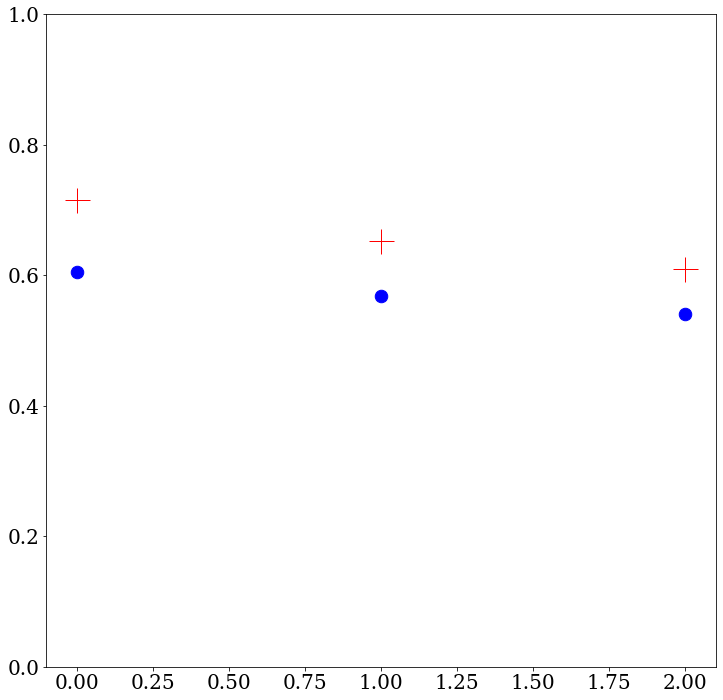

In [22]:
f, ax = plt.subplots(figsize=(12,12))

plt.rc('text',usetex=False)
plt.rc('font',family='serif')
plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=18)
plt.rc('legend',**{'numpoints':1,'fontsize':18,'handlelength':2})

ax.plot(basic_classifier_.loss_curve,'r+',ms=25,label='train')
ax.plot(basic_classifier_.loss_curve_test,'b.',ms=25,label='test')
ax.set_ylim(0,1)

In [23]:
y_pred = basic_classifier_.make_predictions(basic_classifier_.coefs_,X_train_dilute)

In [24]:
xx, yy = np.meshgrid(np.arange(-np.pi, np.pi+0.1, 0.1), np.arange(-np.pi, np.pi+0.1, 0.1))

In [25]:
BC_boundary = basic_classifier_.make_predictions(basic_classifier_.coefs_,np.c_[xx.ravel(), yy.ravel(),np.zeros((len(xx.ravel()),7))])
BC_boundary = BC_boundary.reshape(xx.shape)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 150 but corresponding boolean dimension is 160

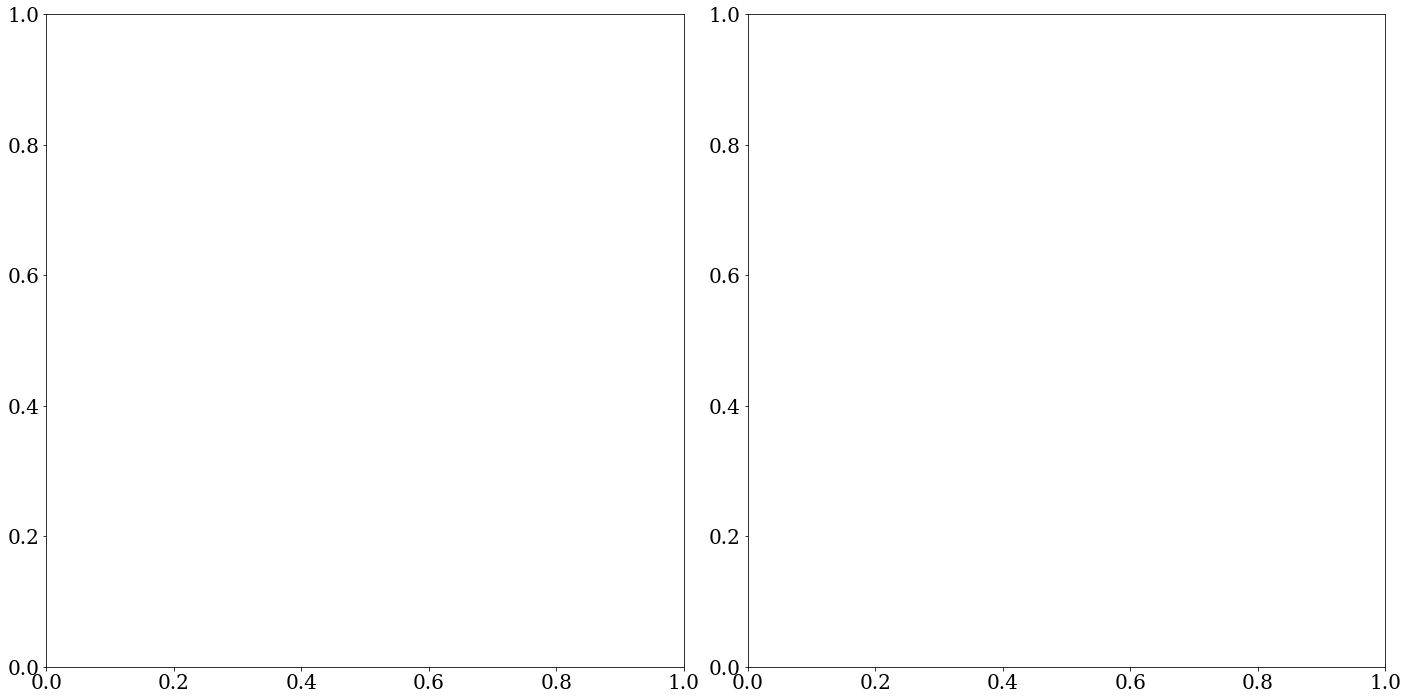

In [134]:
f, ax = plt.subplots(ncols=2,figsize=(24,12))

plt.rc('text',usetex=False)
plt.rc('font',family='serif')
plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=18)
plt.rc('legend',**{'numpoints':1,'fontsize':18,'handlelength':2})

# add a big axis, hide frame
f.add_subplot(111,frameon=False) 
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)


f.subplots_adjust( wspace=0.1,hspace=0.2 )

plot2d_data(X_train_dilute,y_train, fig=f, ax=ax[0])
plot2d_boundary_data(X_train_dilute,y_pred,xx,yy,BC_boundary, fig=f, ax=ax[1])


A word of caution -- with the `QNN` class, the final trained model (i.e. parameters) are stored in `.coefs_`.  Also the loss trace and accuracies tracked during training are stored in `.loss_curve` and `.accuracy_curve`.  These can be saved to a file for future use.

If you was to train on a different set of data, the training will start with those stored values.  To re-initialize the model  make sure to set `.coefs_ = None`, `.loss_curve=[]`, and `.accuracy_curve=[]`. This can be done using the `.reset()` method.

For example, if you want to re-train the same QNN using the features padded with random noise.

In [27]:
basic_classifier_._reset_()

In [28]:
basic_classifier_.fit(X_train_padNoise,y_train,X_test_padNoise,y_test)

initial loss and accuracy (random model):  0.7201902335448389 0.50625
Epoch:  1 | Loss: 0.645745 | Train accuracy: 0.593750
Epoch:  2 | Loss: 0.597008 | Train accuracy: 0.681250
Epoch:  3 | Loss: 0.562827 | Train accuracy: 0.718750


(0.0, 1.0)

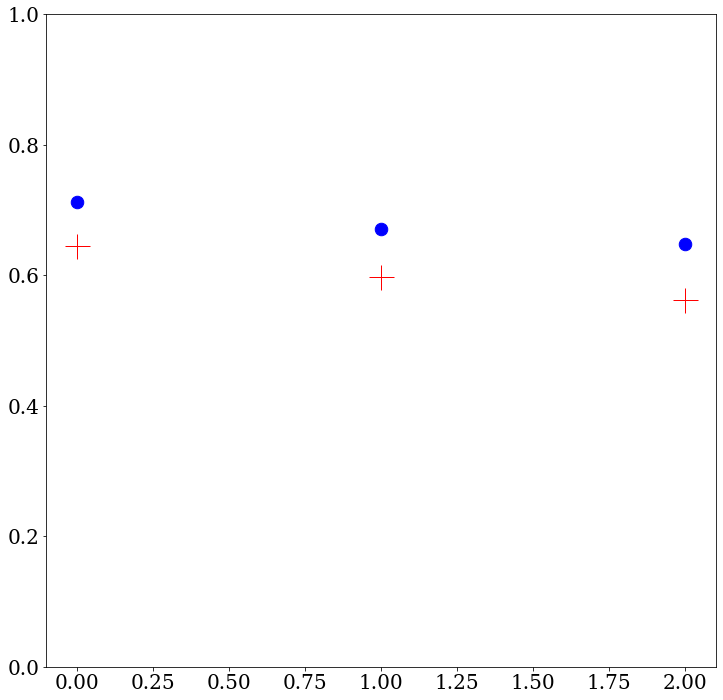

In [29]:
f, ax = plt.subplots(figsize=(12,12))

plt.rc('text',usetex=False)
plt.rc('font',family='serif')
plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=18)
plt.rc('legend',**{'numpoints':1,'fontsize':18,'handlelength':2})

ax.plot(basic_classifier_.loss_curve,'r+',ms=25,label='train')
ax.plot(basic_classifier_.loss_curve_test,'b.',ms=25,label='test')
ax.set_ylim(0,1)

## Using a Data Re Uploading QNN

The examples above can also be executed using the data re-uploading QNN.  The same processed features can be used.  

In [30]:
dru_classifier_ = druQNN(wires=n_qubits,shots=None,\
                                  max_iter=max_steps,edge_list=edge_list,\
                            layers=n_layers,batch_size=32,\
                                 learning_rate=alpha
                            )

In [31]:
dru_classifier_.__dict__

{'n_wires': 3,
 'n_layers': 6,
 'edge_list': ([0, 1], [2, 1]),
 'dev_wires': [tensor(0, requires_grad=True),
  tensor(1, requires_grad=True),
  tensor(2, requires_grad=True)],
 'n_shots': None,
 'coefs_': None,
 'output_qubits': [0],
 'device': <DefaultQubit device (wires=3, shots=None) at 0x1283147c0>,
 'learning_rate': 0.01,
 'batch_size': 32,
 'max_iter': 3,
 'tol': 0.001,
 'wait_time': 10,
 'loss_curve': [],
 'accuracy_curve': []}

In [32]:
dru_classifier_.fit(X_train_padNoise,y_train,X_test_padNoise,y_test)

initial loss and accuracy (random model):  0.690474326723596 0.59375
Epoch:  1 | Loss: 0.639601 | Train accuracy: 0.662500
Epoch:  2 | Loss: 0.588496 | Train accuracy: 0.706250
Epoch:  3 | Loss: 0.540597 | Train accuracy: 0.775000


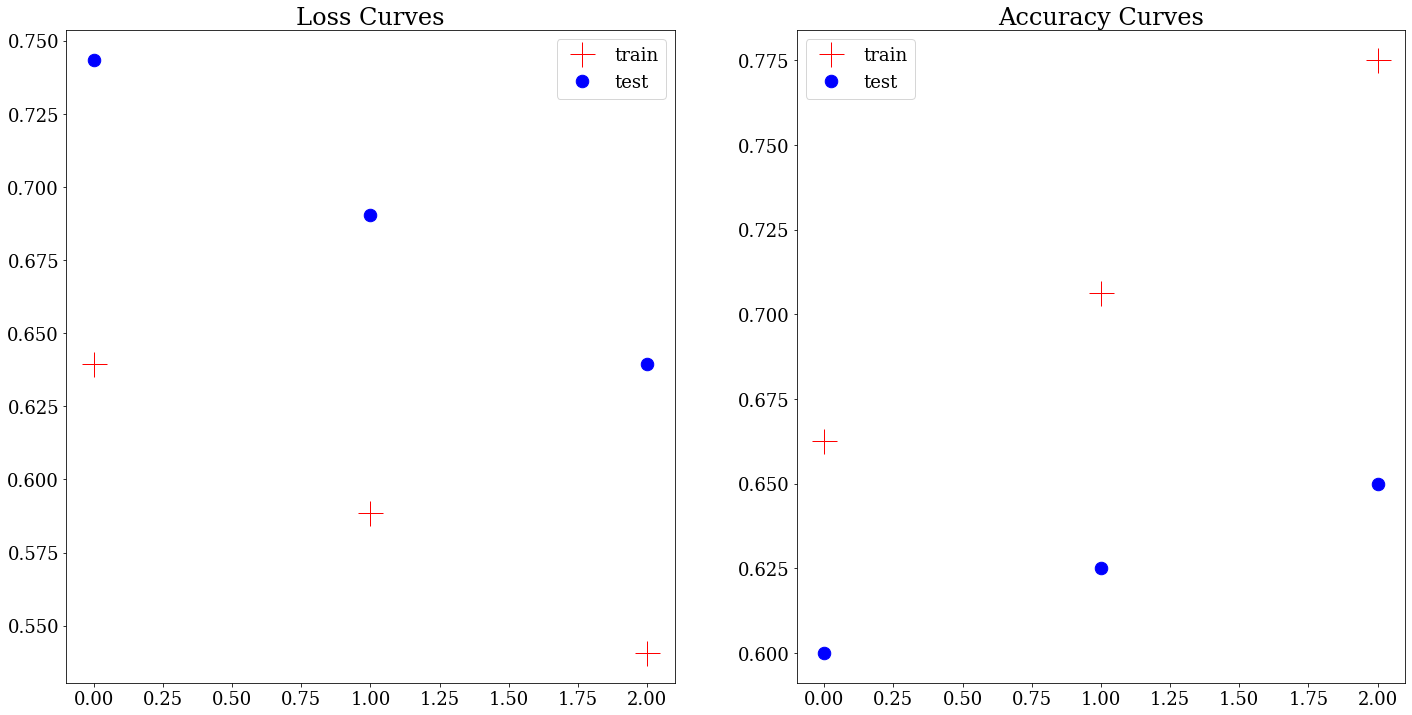

In [33]:
f, ax = plt.subplots(ncols=2,figsize=(24,12))

plt.rc('text',usetex=False)
plt.rc('font',family='serif')
plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=18)
plt.rc('legend',**{'numpoints':1,'fontsize':18,'handlelength':2})

ax[0].plot(dru_classifier_.loss_curve,'r+',ms=25,label='train')
ax[0].plot(dru_classifier_.loss_curve_test,'b.',ms=25,label='test')
ax[0].set_title("Loss Curves",fontsize=24)
ax[0].legend()
ax[1].plot(dru_classifier_.accuracy_curve,'r+',ms=25,label='train')
ax[1].plot(dru_classifier_.accuracy_curve_test,'b.',ms=25,label='test')
ax[1].set_title("Accuracy Curves",fontsize=24)
ax[1].legend()

## Using a set of text features

The previous two datasets (`TwoMoons` and `noise`). This next example uses features extracted from the IMDB dataset for a text classifiation (discerning positive versus negative reviews).  The features in the external file `imdb_data_subset.csv` have been procesed using `doc2vec` to generate features of length 2. 

The full IMDB dataset contains 50K labeled examples.  But due to time, and for demonstration purposes we do not train over the entire dataset.  Instead, we only extract a small fraction of the dataset for training and testing. There are 1000 samples in the file `imdb_data_subset.csv` and they are shuffled already, so we can use simple slciing of the data samples. 

## Import IMDB features

In [34]:
data_dir = '/../' #Replace with the directory that you cloned the repo to

imdb_data = pd.read_csv('/'.join([data_dir,'imdb_data_subset.csv']))
imdb_data = imdb_data.replace({'sentiment': {'positive': 1, 'negative': 0}}) #map the class labels to binary values


imdb_training_data = imdb_data.head(150)
imdb_training_features = np.asarray([np.asarray(eval(x)) for x in imdb_training_data.doc2vec.values],requires_grad=False)
imdb_training_features = rescale_features(imdb_training_features)

imdb_training_labels = np.asarray([int(x) for x in imdb_training_data.sentiment.values])

imdb_testing_data = imdb_data.tail(50)
imdb_testing_features = np.asarray([np.asarray(eval(x)) for x in imdb_testing_data.doc2vec.values],requires_grad=False)
imdb_testing_features = rescale_features(imdb_testing_features)
imdb_testing_labels = np.asarray([int(x) for x in imdb_testing_data.sentiment.values])

In [35]:
dru_classifier_._reset_()
dru_classifier_.fit(imdb_training_features,imdb_training_labels,imdb_testing_features,imdb_testing_labels)

initial loss and accuracy (random model):  0.6735650128533819 0.5866666666666667
Epoch:  1 | Loss: 0.666060 | Train accuracy: 0.573333
Epoch:  2 | Loss: 0.658956 | Train accuracy: 0.606667
Epoch:  3 | Loss: 0.652519 | Train accuracy: 0.606667


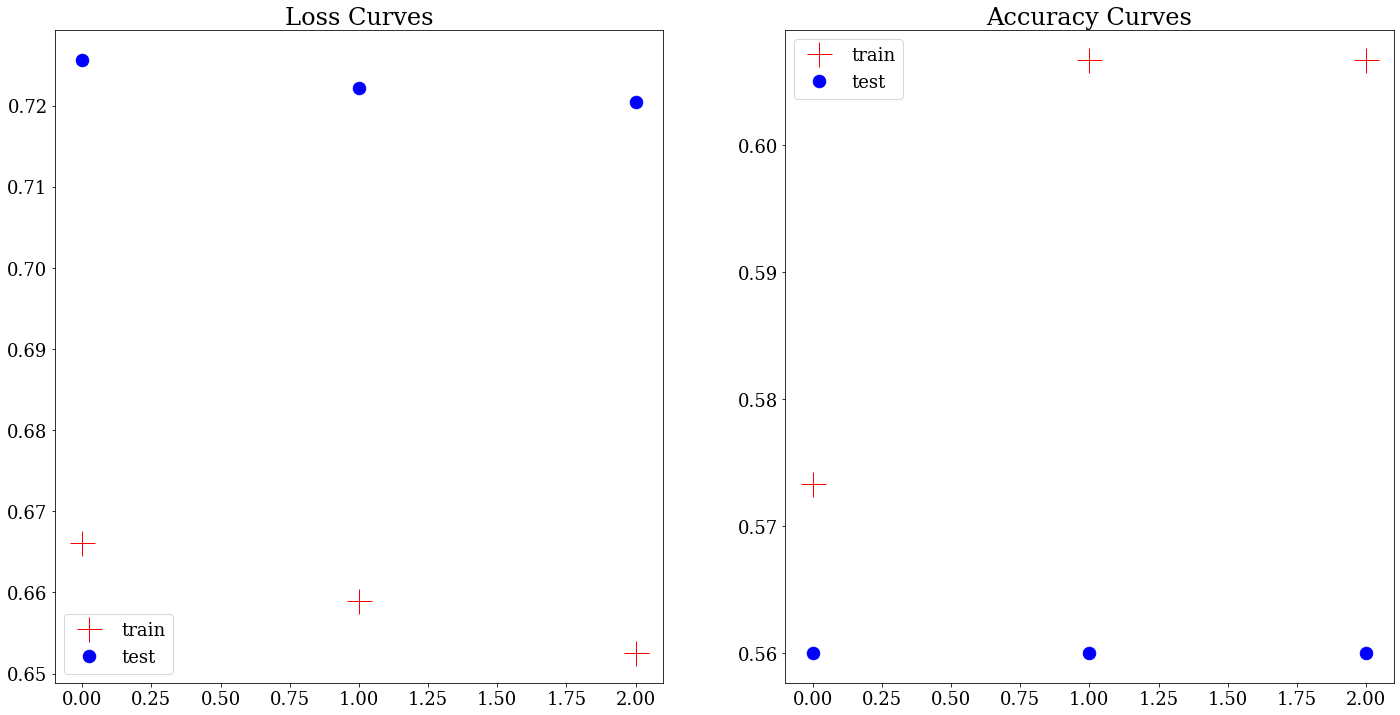

In [36]:
f, ax = plt.subplots(ncols=2,figsize=(24,12))

plt.rc('text',usetex=False)
plt.rc('font',family='serif')
plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=18)
plt.rc('legend',**{'numpoints':1,'fontsize':18,'handlelength':2})

ax[0].plot(dru_classifier_.loss_curve,'r+',ms=25,label='train')
ax[0].plot(dru_classifier_.loss_curve_test,'b.',ms=25,label='test')
ax[0].set_title("Loss Curves",fontsize=24)
ax[0].legend()
ax[1].plot(dru_classifier_.accuracy_curve,'r+',ms=25,label='train')
ax[1].plot(dru_classifier_.accuracy_curve_test,'b.',ms=25,label='test')
ax[1].set_title("Accuracy Curves",fontsize=24)
ax[1].legend()

# Multiclass Classification

We can also use QNNs for multiclass classification.  The modifications needed for our exisitng `binaryQNN` class are:
* use Categorical Cross Entropy instead of Binary Cross Entropy
* Define a way to extract more than 2 labels

The label extraction method we are choosing to use is implemented with 3 steps: 
1) measure 3 qubits and generate a distribution over bitstrings (more than just `0` and `1`) 

2) downselecting the low weight bitstrings (`001`, `010`, `100`) 

3) renormalizing these amplitudes using a sigmoid function.  

In [79]:
class multiclassQNN(object):
    '''
    build a Quantum Neural Network where label extraction is done via bitstring probabilities
    '''
    def __init__(self, wires=3,layers=1,shots=None,edge_list=[],\
                    max_iter=32,tol=1e-3,output_qubits=[0,1,2],\
                        batch_size=16,learning_rate=0.05,coefs=None,**kwargs):
        self.n_wires = wires #QNN wires
        self.n_layers=layers #QNN layers
        self.edge_list=edge_list #Connectivity for the entangling layers
        self.dev_wires = [np.array(idx, requires_grad=True) for idx in range(self.n_wires)] #whole register
        self.n_shots=shots #samples to take to generate bitstring probabilities
        self.coefs_=coefs #stored model parameters
        assert wires>=len(output_qubits), 'need to add more qubits to your circuit'
        self.output_qubits = output_qubits #which qubits to measure for output
        self.device = qml.device("default.qubit", wires=self.dev_wires,shots=self.n_shots) #Pennylane qubit device
        self.learning_rate=learning_rate # learning rate for optimizer
        self.batch_size=batch_size #batch size for batched gradient descent
        self.max_iter = max_iter #maximum number of epochs
        self.tol=tol #tolerance to detect early stopping
        self.wait_time = 10 #number of epochs with no change that triggers early stopping
        
    def build_circuit(self,*args, **kwds):
        raise NotImplementedError
        
    def initialize_params(self):
        params = 2.*np.pi*np.random.random(3*self.n_wires*self.n_layers)
        self.coefs_=params.copy()
        
    def accuracy_score(self,y_true, y_pred):
        """Accuracy score.

        Args:
            y_true (array[float]): 1-d array of targets
            y_predicted (array[float]): 1-d array of predictions
        Returns:
            score (float): the fraction of correctly classified samples
        """
        if (y_true.ndim==1) and (y_pred.ndim==1):
            score = y_true == y_pred
        elif (y_true.ndim>1) and (y_pred.ndim==1):
            score = np.argmax(y_true,axis=1) == y_pred
        else:
            score = np.argmax(y_true,axis=1) == np.argmax(y_pred,axis=1)
        return score.sum() / len(score)

    def softmax(self,P):
        """Compute softmax values for each sets of scores in x."""
        P = np.asarray(P).astype(float)
        e_x = np.exp(P - np.max(P))
        return e_x / e_x.sum()

    def make_predictions(self,params,x):
        """
        assign labels to some data features
        """
        predicted = []
        qnode_ = qml.QNode(self.build_circuit, self.device)
        for i in range(len(x)):
            decoded = np.zeros(len(self.output_qubits))
            P = qnode_(params,x[i])
            w_states = [P[idc] for idc in [1,2,4]]  # downselect on low weight states
            decoded[np.argmax(self.softmax(w_states))]=1
            predicted.append(decoded)
        return np.array(predicted)

    def class_probabilities(self,params,x):
        predicted = []
        qnode_ = qml.QNode(self.build_circuit, self.device)
        for i in range(len(x)):
            P = qnode_(params,x[i])
            w_states = [P[idc] for idc in [1,2,4]]  # downselect on low weight states
            class_probs=self.softmax(w_states)
            predicted.append(class_probs)
        return np.array(predicted)

    def loss_function(self,params,x, y):
        """
        Cost function to be minimized.

        Args:
          params (array[float]): array of parameters
          x (array[float]): 2-d array of input vectors
          y (array[float]): 1-d array of targets

        Returns:
          float: loss value to be minimized
        """
        # Compute prediction for each input in data batch
        loss = 0.0
        qnode_ = qml.QNode(self.build_circuit, self.device)
        for i in range(len(x)):
            P = qnode_(params,x[i])
            w_states = [P[idc] for idc in [1,2,4]] # downselect on low weight states
            qp = self.softmax(w_states)
            yp = y[i] # one hot encoded label
            loss = loss - np.sum(yp * np.log(qp+10**-12))
        return loss / len(x)

    def iterate_minibatches(self,inputs, targets, batch_size):
        """
        A generator for batches of the input data

        Args:
            inputs (array[float]): input data
            targets (array[float]): targets

        Returns:
            inputs (array[float]): one batch of input data of length `batch_size`
            targets (array[float]): one batch of targets of length `batch_size`
        """
        for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
            idxs = slice(start_idx, start_idx + batch_size)
            yield inputs[idxs], targets[idxs]
            
    def fit(self,X,y,Xtest=None,ytest=None):
        """
        implement gradient based training
        """
        if (Xtest is not None) and (ytest is not None):
            #if you provide the testing data that will allso be used during evaluating hte loss and accuracy curves
            self.loss_curve_test = []
            self.accuracy_curve_test = []
            
        opt = qml.optimize.AdamOptimizer(self.learning_rate, beta1=0.9, beta2=0.999)

        if self.coefs_ is None:
            # initialize random weights
            self.initialize_params()
            params = self.coefs_.copy()
        else:
            params = self.coefs_

        if len(X)<self.batch_size:
            self.batch_size = int(len(X))
            print('WARNING: number of samples is smaller'+\
             'than current batch size \n '+\
             'Resetting batch size for all trainings to: '+str(self.batch_size))
        loss = self.loss_function(params,X, y)
        preds = self.make_predictions(params,X)
        accuracy = self.accuracy_score(y, preds)
        print('initial loss and accuracy (random model): ',loss,accuracy)
        best_loss=loss
        best_accuracy=accuracy
        iter_count=0

        for it in range(self.max_iter):
            for Xbatch, ybatch in self.iterate_minibatches(X, y, batch_size=self.batch_size):
                params = opt.step(lambda v: self.loss_function(v, Xbatch, ybatch), params)
                self.coefs_ = params.copy()
            # check for early stopping
            loss = self.loss_function(params,X, y)
            preds = self.make_predictions(params,X)
            accuracy = self.accuracy_score(y, preds)
            self.loss_curve.append(loss.numpy())
            self.accuracy_curve.append(accuracy.numpy())
            if (Xtest is not None) and (ytest is not None):
                self.loss_curve_test.append(self.loss_function(params,Xtest, ytest).numpy())
                testPreds=self.make_predictions(params,Xtest)
                self.accuracy_curve_test.append(self.accuracy_score(ytest,testPreds).numpy())
            if np.abs(best_loss-loss)<self.tol:
                iter_count+=1
            elif best_loss-loss>self.tol:
                best_loss = loss
                iter_count=0
            if iter_count>self.wait_time:
                print('early stopping ')
                print(
                  "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f}".format(
                      it+1, loss, accuracy
                  )
                )
                break
            else:
                print(
                      "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f}".format(
                          it+1, loss, accuracy
                      )
                    )

In [80]:
class MultiClassDruQNN(multiclassQNN):
    '''
    build a Quantum Neural Network where label extraction is done via bitstring probabilities
    using data re-uploading
    '''
    def __init__(self, **kwargs):
        super(MultiClassDruQNN,self).__init__(**kwargs)
        self.loss_curve=[]
        self.accuracy_curve=[]
        
    def _reset_(self):
        self.coefs_=None
        self.loss_curve=[]
        self.accuracy_curve=[]
        
    def build_circuit(self,params,x=None):
        shape = (-1,len(self.dev_wires),3)
        params = np.asarray(params).reshape(shape)
        #x = np.resize(x, params.shape[0]-1)
        
        for idx in range(params.shape[0]-1):
            qml.layer(AngleEncodingLayer,1,x=x,dev_wires=self.dev_wires)
            qml.layer(EdgeListLayer, 1,[params[idx]],\
                            dev_wires=self.dev_wires,\
                            edge_list=self.edge_list)
        return qml.probs(wires=[self.dev_wires[ix] for ix in self.output_qubits])

class MultiClassBasicQNN(multiclassQNN):
    '''
    build a Quantum Neural Network where label extraction is done via bitstring probabilities
    using data re-uploading
    '''
    def __init__(self,**kwargs):
        super(MultiClassBasicQNN,self).__init__(**kwargs)
        self.loss_curve=[]
        self.accuracy_curve=[]
    
    def _reset_(self):
        self.coefs_=None
        self.loss_curve=[]
        self.accuracy_curve=[]
        
    def build_circuit(self,params,x=None):
        shape = (-1,len(self.dev_wires),3)
        params = np.asarray(params).reshape(shape)
        #x = np.resize(x, params.shape[0]-1)
        qml.layer(AngleEncodingLayer,1,x=x,dev_wires=self.dev_wires)
        for idx in range(params.shape[0]-1):
            qml.layer(EdgeListLayer, 1,[params[idx]],\
                            dev_wires=self.dev_wires,\
                            edge_list=self.edge_list)
        return qml.probs(wires=[self.dev_wires[ix] for ix in self.output_qubits])

## Generate the Data

For this example, we're going to use the random features, random labels dataset

In [87]:
noise_train_features = (2*np.pi)*np.random.random((150,9)) #generate uniform random samples on [0,2pi]
noise_test_features = (2*np.pi)*np.random.random((50,9)) #generate uniform random samples on [0,2pi]

noise_train_labels = np.asarray(np.random.choice(3, size=150, replace=True),requires_grad=False) #generate 3 random categorical labels
noise_test_labels = np.asarray(np.random.choice(3, size=50, replace=True),requires_grad=False) #generate 3 random categorical labels

noise_onehot_train_labels = np.asarray(one_hot_encode_labels(noise_train_labels,3),requires_grad=False)
noise_onehot_test_labels = np.asarray(one_hot_encode_labels(noise_test_labels,3),requires_grad=False)

In [88]:
X_train_dilute = np.asarray(np.hstack(((2*np.pi)*np.random.random((150,3)),np.zeros((len(noise_train_features),6)))),requires_grad=False)
X_test_dilute = np.asarray(np.hstack(((2*np.pi)*np.random.random((50,3)),np.zeros((len(noise_test_features),6)))),requires_grad=False)

X_train_dilute[0].numpy()

array([2.63687637, 5.45317387, 4.03953609, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

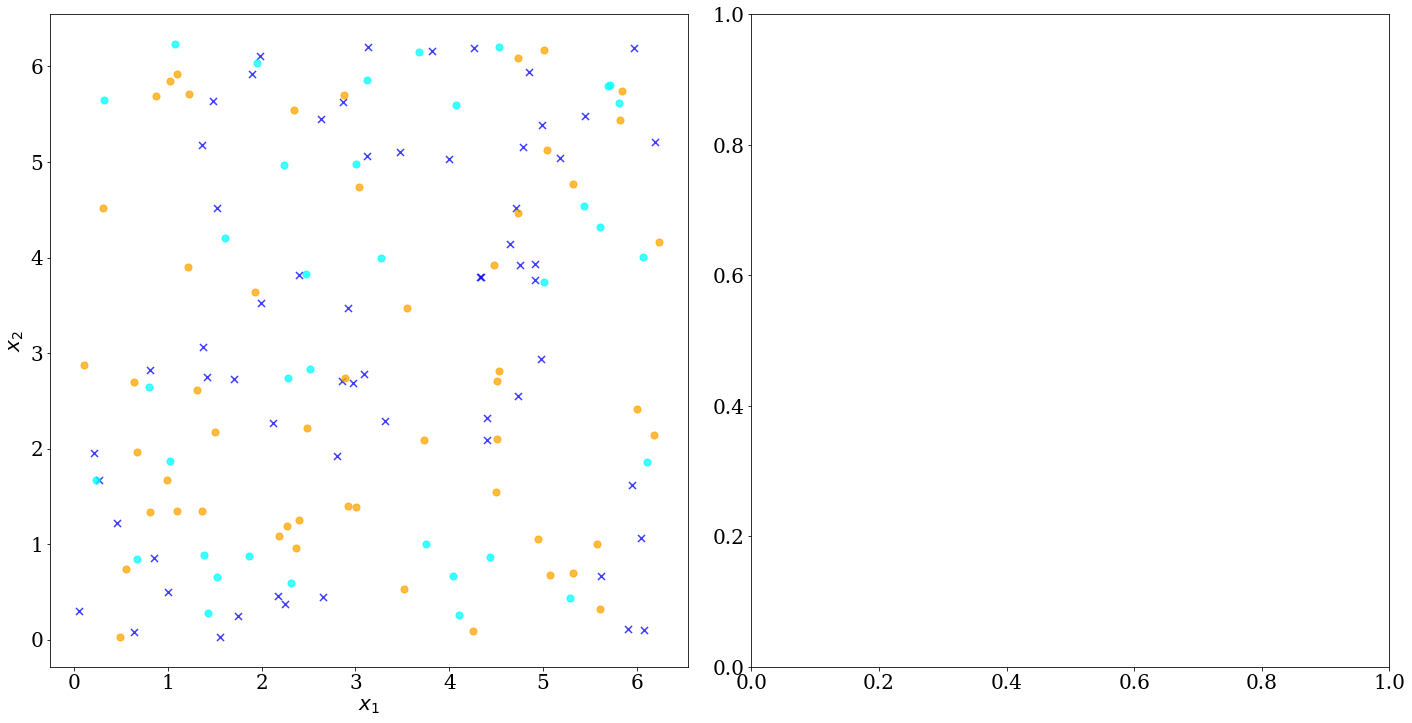

In [136]:
f, ax = plt.subplots(ncols=2,figsize=(24,12))

plt.rc('text',usetex=False)
plt.rc('font',family='serif')
plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=18)
plt.rc('legend',**{'numpoints':1,'fontsize':18,'handlelength':2})

# add a big axis, hide frame
f.add_subplot(111,frameon=False) 
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)


f.subplots_adjust( wspace=0.1,hspace=0.2 )

plot2d_data(X_train_dilute,noise_train_labels, fig=f, ax=ax[0])


# Build a Multiclass Classifier

In [99]:
n_layers = 6 # number of ansatz layers
n_qubits = 3 # number of qubits
max_steps=10 # maximum number of epochs 
alpha = 0.01
edge_list = [0,1],[2,1]

In [100]:
multiclass_classifier_ = MultiClassDruQNN(wires=n_qubits,shots=None,\
                                  max_iter=max_steps,edge_list=edge_list,\
                            layers=n_layers,batch_size=32,\
                                 learning_rate=alpha,output_qubits=[0,1,2]
                            )

In [101]:
multiclass_classifier_.__dict__

{'n_wires': 3,
 'n_layers': 6,
 'edge_list': ([0, 1], [2, 1]),
 'dev_wires': [tensor(0, requires_grad=True),
  tensor(1, requires_grad=True),
  tensor(2, requires_grad=True)],
 'n_shots': None,
 'coefs_': None,
 'output_qubits': [0, 1, 2],
 'device': <DefaultQubit device (wires=3, shots=None) at 0x12c1223a0>,
 'learning_rate': 0.01,
 'batch_size': 32,
 'max_iter': 10,
 'tol': 0.001,
 'wait_time': 10,
 'loss_curve': [],
 'accuracy_curve': []}

In [102]:
multiclass_classifier_.fit(noise_train_features,noise_onehot_train_labels,noise_test_features,noise_onehot_test_labels)

initial loss and accuracy (random model):  1.099607287574506 0.3333333333333333
Epoch:  1 | Loss: 1.096725 | Train accuracy: 0.340000
Epoch:  2 | Loss: 1.093544 | Train accuracy: 0.353333
Epoch:  3 | Loss: 1.090302 | Train accuracy: 0.366667
Epoch:  4 | Loss: 1.087030 | Train accuracy: 0.380000
Epoch:  5 | Loss: 1.083751 | Train accuracy: 0.426667
Epoch:  6 | Loss: 1.080488 | Train accuracy: 0.440000
Epoch:  7 | Loss: 1.077272 | Train accuracy: 0.433333
Epoch:  8 | Loss: 1.074133 | Train accuracy: 0.446667
Epoch:  9 | Loss: 1.071105 | Train accuracy: 0.460000
Epoch: 10 | Loss: 1.068216 | Train accuracy: 0.486667


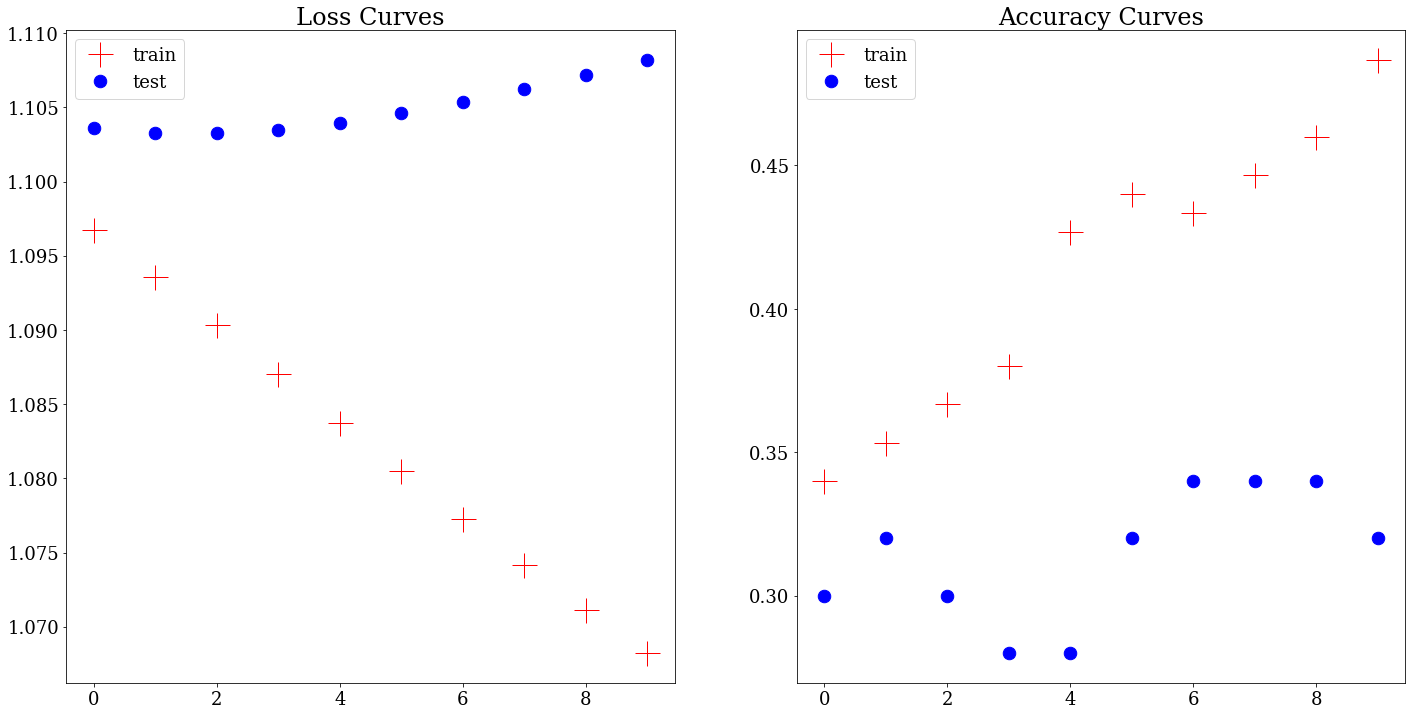

In [103]:
f, ax = plt.subplots(ncols=2,figsize=(24,12))

plt.rc('text',usetex=False)
plt.rc('font',family='serif')
plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=18)
plt.rc('legend',**{'numpoints':1,'fontsize':18,'handlelength':2})

ax[0].plot(multiclass_classifier_.loss_curve,'r+',ms=25,label='train')
ax[0].plot(multiclass_classifier_.loss_curve_test,'b.',ms=25,label='test')
ax[0].set_title("Loss Curves",fontsize=24)
ax[0].legend()
ax[1].plot(multiclass_classifier_.accuracy_curve,'r+',ms=25,label='train')
ax[1].plot(multiclass_classifier_.accuracy_curve_test,'b.',ms=25,label='test')
ax[1].set_title("Accuracy Curves",fontsize=24)
ax[1].legend()

In [111]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [105]:
noise_train_labels

tensor([0, 1, 2, 0, 2, 1, 0, 0, 1, 1, 0, 2, 1, 1, 0, 0, 1, 0, 1, 1, 2, 2,
        0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 2, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 2,
        2, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 2, 1, 1, 1, 2, 0, 2, 1, 0,
        1, 0, 1, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 2, 0, 2, 0,
        1, 2, 2, 0, 0, 1, 0, 1, 0, 2, 2, 1, 1, 0, 1, 2, 0, 1, 2, 2, 2, 1,
        0, 2, 1, 1, 0, 2, 0, 0, 1, 1, 1, 0, 0, 2, 1, 1, 1, 0, 2, 1, 1, 0,
        1, 2, 2, 0, 1, 2, 0, 0, 1, 2, 0, 1, 1, 2, 2, 2, 1, 1], requires_grad=False)

In [106]:
predicted_train_labels = multiclass_classifier_.make_predictions(multiclass_classifier_.coefs_,noise_train_features)
predicted_test_labels = multiclass_classifier_.make_predictions(multiclass_classifier_.coefs_,noise_test_features)

In [107]:
predicted_train_categorical = [np.argmax(x) for x in predicted_train_labels]
predicted_test_categorical = [np.argmax(x) for x in predicted_test_labels]

<Axes: >

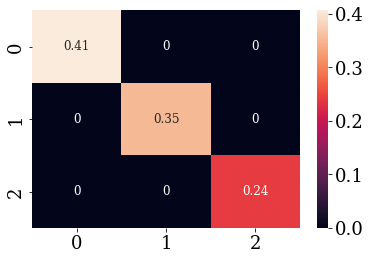

In [117]:
sns.heatmap(confusion_matrix(noise_train_labels,noise_train_labels,normalize='all'),annot=True)

<Axes: >

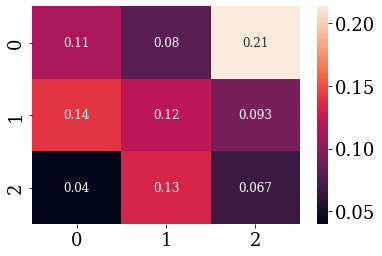

In [118]:
sns.heatmap(confusion_matrix(noise_train_labels,predicted_train_categorical,normalize='all'),annot=True)

<Axes: >

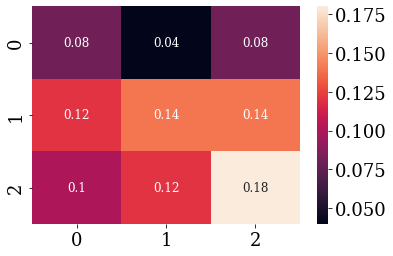

In [119]:
sns.heatmap(confusion_matrix(noise_test_labels,predicted_test_categorical,normalize='all'),annot=True)